## Data loading

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import Model,Sequential
from tensorflow.keras.optimizers import SGD,Adam
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt

# Set seed for reproducibility
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [3]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test  = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

train.shape, test.shape

((42000, 785), (28000, 784))

In [4]:
X_train = train.drop('label',axis=1)
y_train = train['label']
X_test = test.copy()

# Normalize the data

X_train = X_train / 255.0
X_test  = X_test / 255.0

# Reshape image in 3 dimensions (height = 28px, width = 28px , chanal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
X_test  = X_test.values.reshape(-1,28,28,1)


# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 10)
#y_test = tf.keras.utils.to_categorical(y_test, num_classes = 10)


classes = np.unique(np.argmax(y_train, axis=1)).astype(str)




In [5]:
X_test.shape


#X_train.shape

(28000, 28, 28, 1)

In [6]:
list(y_train[3,:])

[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [7]:
classes

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U21')

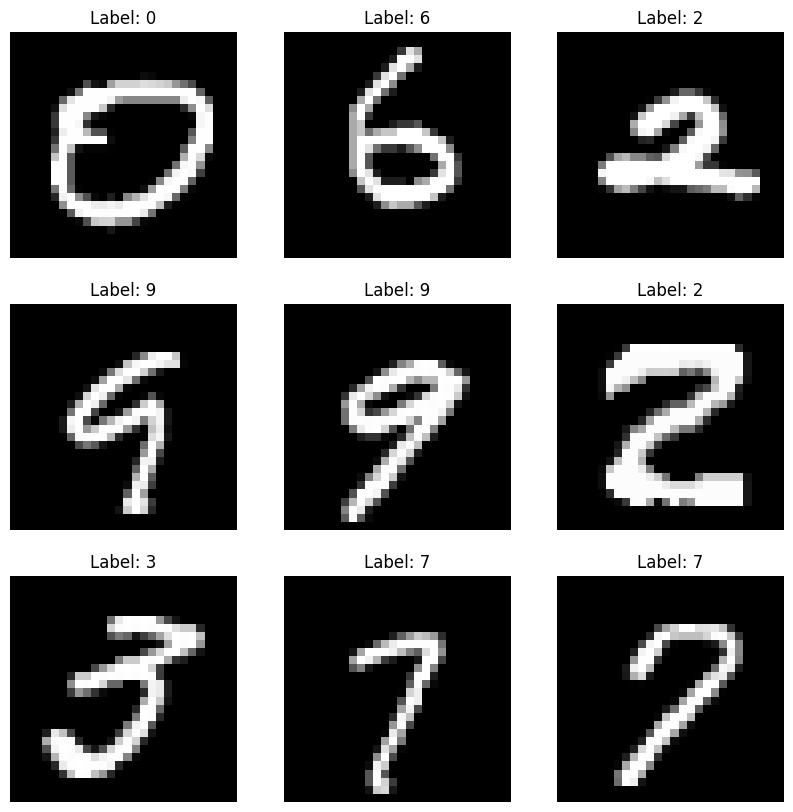

In [8]:
# plot random 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    random_index = np.random.randint(0, len(X_train))
    plt.imshow(X_train[random_index].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {np.argmax(y_train[random_index])}")
    plt.axis('off')
plt.show()


## Model Building- CNN

In [9]:
# Train-validation splitting
X_tr,X_val,y_tr,y_val = train_test_split(X_train,y_train,
                                                test_size=0.1
                                         )

Model: "sequential_CNN_MNIST"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)               │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_11 (Conv2D)              │ (None, 28, 28, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Maxpool_2x2_1 (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_22 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Maxpool_2x2_2 (MaxPooling2D)    │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_3 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Maxpool_2x2_5 (MaxPooling2D)    │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3, 3, 128)      │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3, 3, 128)      │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,664 (740.88 KB)

 Trainable params: 189,216 (739.12 KB)

 Non-trainable params: 448 (1.75 KB)

Number of parameters: 264106


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_CNN_MNIST            │ (None, 1152)           │       189,664 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,106 (1.01 MB)

 Trainable params: 263,658 (1.01 MB)

 Non-trainable params: 448 (1.75 KB)

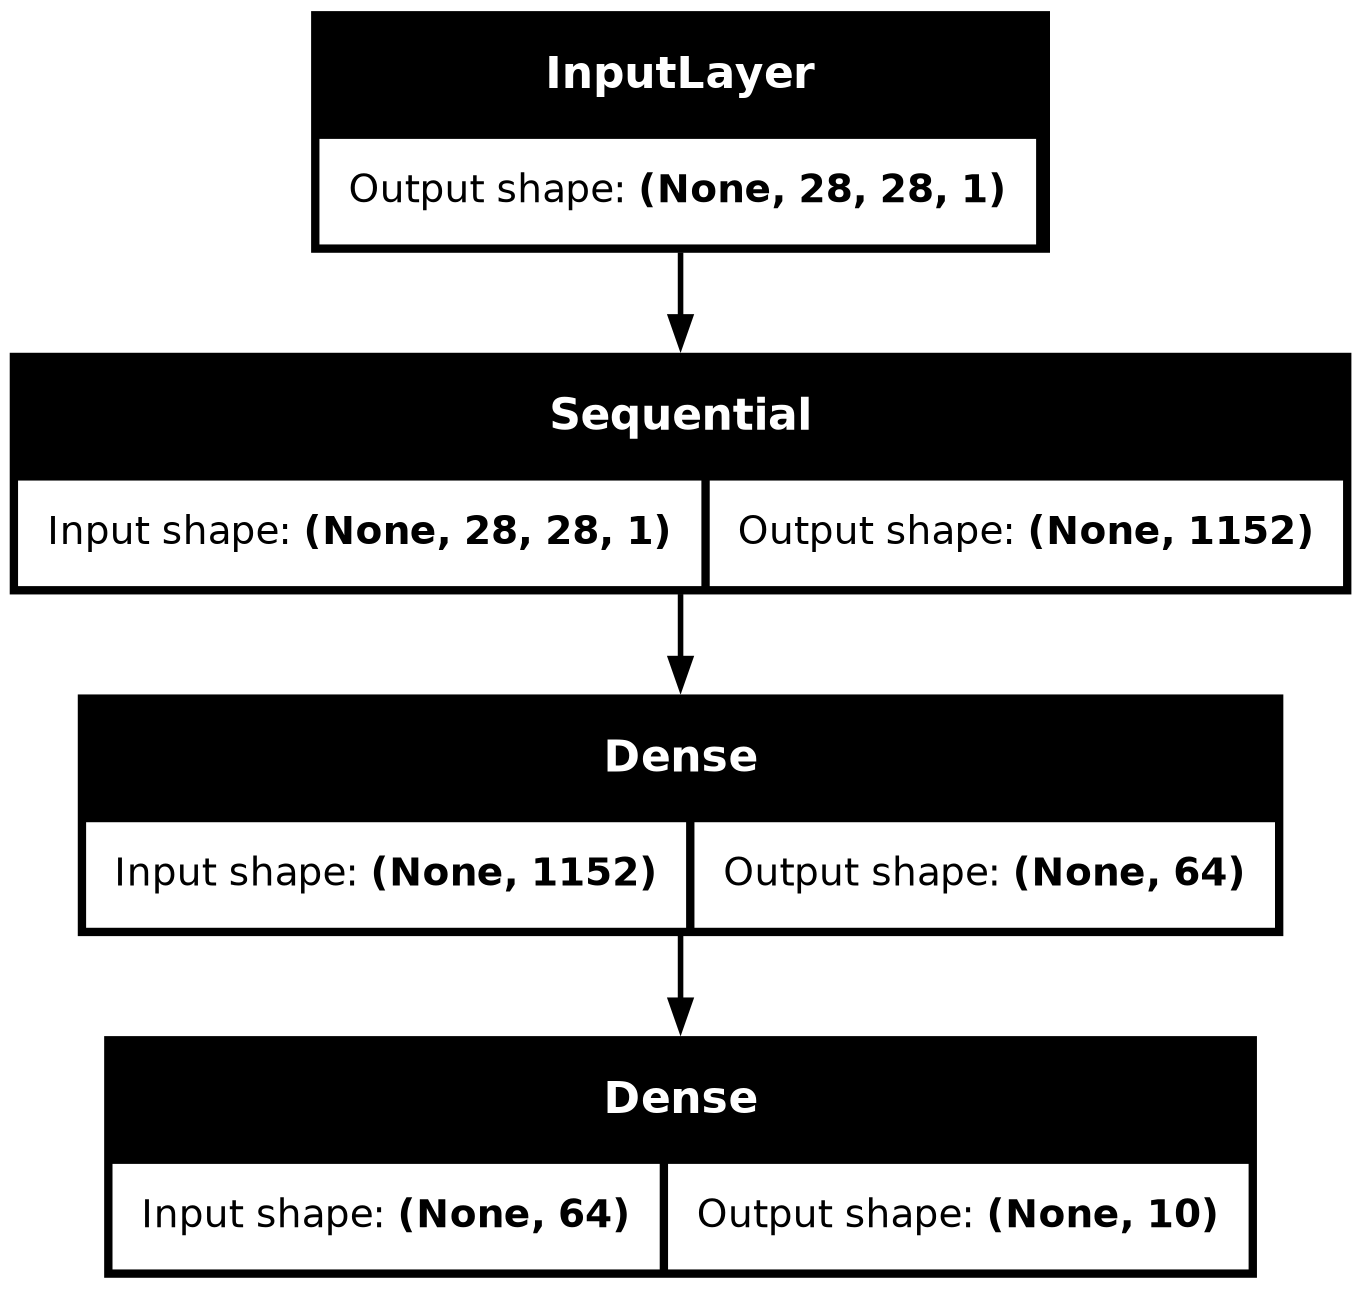

In [10]:
# Define the CNN model
#from tensorflow.keras.layers import LeakyReLU
DROPOUT = 0.4
feature_extractor = Sequential(name='sequential_CNN_MNIST')
feature_extractor.add(Input(shape=(28,28,1), name='input Layer'))
feature_extractor.add(Conv2D(32, (5, 5), activation='relu', name='Conv2D_1',padding = 'Same'))
feature_extractor.add(Conv2D(32, (5, 5), activation='relu', name='Conv2D_11',padding = 'Same'))

feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D((2, 2), name='Maxpool_2x2_1'))
feature_extractor.add(Dropout(DROPOUT))

feature_extractor.add(Conv2D(64, (3, 3), activation='relu', name='Conv2D_2',padding = 'Same'))
feature_extractor.add(Conv2D(64, (3, 3), activation='relu', name='Conv2D_22',padding = 'Same'))

feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D((2, 2), name='Maxpool_2x2_2'))
feature_extractor.add(Dropout(DROPOUT))
#feature_extractor.add(MaxPooling2D((2, 2)), name='Maxpool_2x2_3')
feature_extractor.add(Conv2D(128, (3, 3), activation='relu', name='Conv2D_3',padding = 'Same'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D((2, 2), name='Maxpool_2x2_5'))
feature_extractor.add(Dropout(DROPOUT))





feature_extractor.add( Dense(128,activation='relu'))
feature_extractor.add( Dense(128, activation='relu'))

feature_extractor.add(Flatten())
feature_extractor.summary()


input_tensor = Input(shape=(28,28,1))

# Pass the input tensor through the feature extractor
X = feature_extractor(input_tensor)

# Add the remaining layers to the model
X = Dense(64, activation='relu')(X)

X=feature_extractor.output
X= Dense(64, activation='relu')(X)
prediction_output=Dense(10, activation='softmax')(X)
# Create the model by specifying the input and output tensors
model = Model(inputs=feature_extractor.input, outputs=prediction_output)

# Compile the model
model.compile(RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the number of parameters
print("Number of parameters:", model.count_params())

model.summary()

# Visualize the model architecture
tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def create_regularized_model():
    input_layer = Input(shape=(28, 28, 1))  # Assuming grayscale images

    # First convolutional block with L2 regularization, batch normalization, and dropout
    feature_extraction = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(input_layer)
    feature_extraction = BatchNormalization()(feature_extraction)
    feature_extraction = MaxPooling2D((2, 2))(feature_extraction)
    #feature_extraction = Dropout(0.25)(feature_extraction)

    # Second convolutional block with L2 regularization, batch normalization, and dropout
    feature_extraction = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(feature_extraction)
    feature_extraction = BatchNormalization()(feature_extraction)
    feature_extraction = MaxPooling2D((2, 2))(feature_extraction)
    #feature_extraction = Dropout(0.25)(feature_extraction)

    # Third convolutional block with L2 regularization, batch normalization, and dropout
    feature_extraction = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(feature_extraction)
    feature_extraction = BatchNormalization()(feature_extraction)
    feature_extraction = MaxPooling2D((2, 2))(feature_extraction)
    #feature_extraction = Dropout(0.25)(feature_extraction)

    # Fourth convolutional block with L2 regularization, batch normalization, and dropout
    feature_extraction = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(feature_extraction)
    feature_extraction = BatchNormalization()(feature_extraction)
    feature_extraction = MaxPooling2D((2, 2))(feature_extraction)
    #feature_extraction = Dropout(0.25)(feature_extraction)

    # Flatten and fully connected layers with L2 regularization, batch normalization, and dropout
    feature_extraction = Flatten()(feature_extraction)
    feature_extraction = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(feature_extraction)
    feature_extraction = BatchNormalization()(feature_extraction)
    feature_extraction = Dropout(0.5)(feature_extraction)
    feature_extraction = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(feature_extraction)
    feature_extraction = BatchNormalization()(feature_extraction)
    feature_extraction = Dropout(0.5)(feature_extraction)
    feature_extraction = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(feature_extraction)
    feature_extraction = BatchNormalization()(feature_extraction)
    feature_extraction = Dropout(0.5)(feature_extraction)
    feature_extraction = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(feature_extraction)
    feature_extraction = BatchNormalization()(feature_extraction)
    feature_extraction = Dropout(0.5)(feature_extraction)
    output_layer = Dense(10, activation='softmax', kernel_regularizer=l2(0.01))(feature_extraction)

    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

#model = create_regularized_model()
#model.compile(optimizer=RMSprop(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
#tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_CNN_MNIST            │ (None, 1152)           │       189,664 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,106 (1.01 MB)

 Trainable params: 263,658 (1.01 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to your training data
datagen.fit(X_tr)

In [14]:
# Train the model
# Create the model
BATCH_SIZE = 16
model = create_regularized_model()
#checkpoint_path = "results.weights.h5"

# Compile the model with a lower initial learning rate
initial_learning_rate = 1e-4
model.compile(optimizer=RMSprop(learning_rate=initial_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss',mode='min', factor=0.5, patience=2, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',mode='min', patience=5, restore_best_weights=True)
#checkpoint = ModelCheckpoint(checkpoint_path', monitor='val_loss', save_best_only=True)
# Defining the checkpoint callback
checkpoint_path = "results.weights.h5"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                      save_best_only=True,
                                      monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_freq='epoch')

# Training with callbacks X_tr,X_val,y_tr,y_val
history = model.fit(X_tr, y_tr, batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val), 
                    epochs=100, 
                    callbacks=[reduce_lr, early_stopping, checkpoint_callback])


# Use the generator to train the model with multiple workers
#history = model.fit(datagen.flow(X_tr, y_tr, batch_size=32),
#                    validation_data=(X_val, y_val),
#                    epochs=10,
 #                   callbacks=[reduce_lr, early_stopping, checkpoint_callback],
                    #workers=4,  # Number of workers for parallel processing
                    #use_multiprocessing=True)  # Enable multiprocessing
 #                  )

Epoch 1/100


I0000 00:00:1729240285.919976      69 service.cc:145] XLA service 0x5a1d39698390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729240285.920032      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  45/2363 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.0816 - loss: 15.9964

I0000 00:00:1729240294.989254      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2363/2363 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2780 - loss: 14.2240
Epoch 1: val_loss improved from inf to 8.81666, saving model to results.weights.h5
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - accuracy: 0.2781 - loss: 14.2233 - val_accuracy: 0.9483 - val_loss: 8.8167 - learning_rate: 1.0000e-04
Epoch 2/100
2361/2363 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8438 - loss: 7.8670
Epoch 2: val_loss improved from 8.81666 to 4.14250, saving model to results.weights.h5
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8439 - loss: 7.8653 - val_accuracy: 0.9779 - val_loss: 4.1425 - learning_rate: 1.0000e-04
Epoch 3/100
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9338 - loss: 3.6490
Epoch 3: val_loss improved from 4.14250 to 1.89571, saving model to results.weights.h5
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9338 - loss: 3.6487 - val_accuracy: 0.9833 - val_loss: 1.8957 - learning_rate: 1.0000e-04
Epoch 4/100
2359/2363 ━━━━━━━━━━━━━━━━━━━━ 0

In [15]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001)


In [16]:
# Defining the checkpoint callback
checkpoint_path = "results.weights.h5"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                      save_best_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_freq='epoch')

In [17]:
dummy_input = np.random.random((1, 28, 28, 1))  # Create a dummy input of the same shape as X_tr
model.predict(dummy_input)  # This ensures that the model is now built

# 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


array([[0.00722633, 0.27695447, 0.09757423, 0.3144806 , 0.00404625,
        0.03915284, 0.01986315, 0.00392033, 0.21218532, 0.02459641]],
      dtype=float32)

In [18]:
# Train the model
tf.random.set_seed(42)
with tf.device('/device:GPU:0'):
    history = model.fit(X_tr, y_tr, epochs=50, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr,checkpoint_callback])




Epoch 1/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0287
Epoch 1: val_accuracy improved from -inf to 0.99262, saving model to results.weights.h5
591/591 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 1.0000 - loss: 0.0287 - val_accuracy: 0.9926 - val_loss: 0.0549 - learning_rate: 3.9062e-07
Epoch 2/50
587/591 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0288
Epoch 2: val_accuracy improved from 0.99262 to 0.99286, saving model to results.weights.h5
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 1.0000 - loss: 0.0288 - val_accuracy: 0.9929 - val_loss: 0.0552 - learning_rate: 3.9062e-07
Epoch 3/50
588/591 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0286
Epoch 3: val_accuracy did not improve from 0.99286
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 1.0000 - loss: 0.0286 - val_accuracy: 0.9929 - val_loss: 0.0549 - learning_rate: 3.9062e-07
Epoch 4/50
587/591 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - l

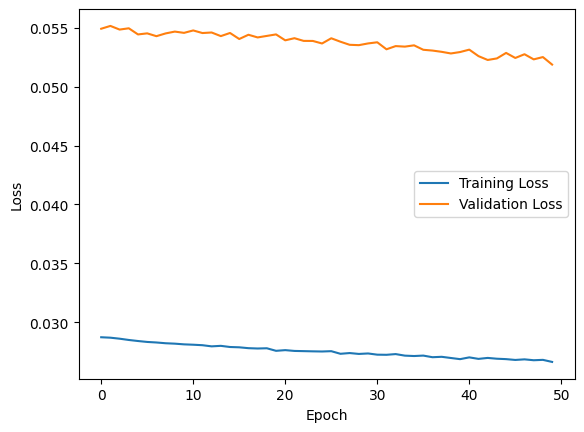

In [19]:
# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


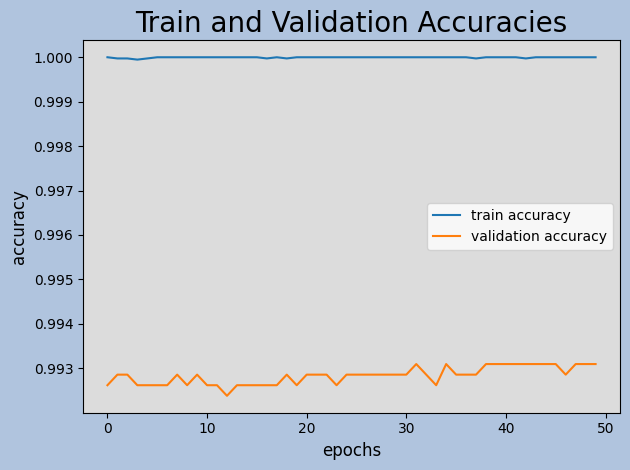

In [20]:

plt.plot(history.history['accuracy'],label='train accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epochs',fontsize=12)
plt.ylabel('accuracy',fontsize=12)
plt.legend()

plt.title('Train and Validation Accuracies',fontsize=20)

plt.tight_layout()
plt.gca().set_facecolor('gainsboro')
plt.gcf().patch.set_facecolor('lightsteelblue')

In [21]:
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score  # Import the accuracy_score function
# Extract features from the CNN (using the convolutional layers)

model(tf.keras.Input(shape=(28, 28, 1)))
# Create a feature extraction model
feature_extractor = Model(inputs=model.input, outputs=model.layers[-1].output)

# Extract CNN features from both training and test data
cnn_features_tr = feature_extractor.predict(X_tr)
cnn_features_val = feature_extractor.predict(X_val)
cnn_features_test = feature_extractor.predict(X_test)




1182/1182 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


## Enhanced Model with Data Augmentation and Pretrained Layers

In [22]:
# Train a Random Forest classifier on the CNN features
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(cnn_features_tr, np.argmax(y_tr, axis=1))

# Predict on the test set
rf_predictions = rf_classifier.predict(cnn_features_val)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(np.argmax(y_val, axis=1), rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.9930952380952381


In [23]:
# prompt: enhance using catxgb

#!pip install catboost

from catboost import CatBoostClassifier

# Train a CatBoost classifier on the extracted features
catboost_classifier = CatBoostClassifier(iterations=100, learning_rate=0.001, depth=4, random_seed=42)
catboost_classifier.fit(cnn_features_tr, np.argmax(y_tr, axis=1), verbose=False)

# Predict on validation data
y_val_pred_catboost = catboost_classifier.predict(cnn_features_val)

# Evaluate the CatBoost classifier
accuracy_catboost = accuracy_score(np.argmax(y_val, axis=1), y_val_pred_catboost)
print("CatBoost Accuracy:", accuracy_catboost)

CatBoost Accuracy: 0.97


In [24]:
from sklearn.svm import SVC

# Train an SVM classifier on the extracted features
svm_classifier = SVC(kernel='rbf', C=20, gamma='scale')  # You can experiment with different kernels and parameters
svm_classifier.fit(cnn_features_tr, np.argmax(y_tr, axis=1))

# Predict on validation data
y_val_pred_svm = svm_classifier.predict(cnn_features_val)

# Evaluate the SVM classifier
accuracy_svm = accuracy_score(np.argmax(y_val, axis=1), y_val_pred_svm)
print("SVM Accuracy:", accuracy_svm)

SVM Accuracy: 0.9930952380952381


Stacking

In [25]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Create a list of estimators (our base models)
estimators = [
    ('rf', rf_classifier),
    #('catboost', catboost_classifier),
    ('svm', svm_classifier)
]

# Define a meta-learner (a model that combines the predictions of the base models)
meta_learner =  SVC(kernel='rbf', C=20, gamma='scale')

# Create a stacking classifier
stacking_model = StackingClassifier(estimators=estimators, final_estimator=meta_learner)

# Train the stacking model on the training features and labels
stacking_model.fit(cnn_features_tr, np.argmax(y_tr, axis=1))

# Predict on validation data
y_val_pred_stacking = stacking_model.predict(cnn_features_val)

# Evaluate the stacking model
accuracy_stacking = accuracy_score(np.argmax(y_val, axis=1), y_val_pred_stacking)
print("Stacking Model Accuracy:", accuracy_stacking)

# Predict on the test set using the stacking model
y_test_pred_stacking = stacking_model.predict(cnn_features_test)

# Create a submission file
submission = pd.DataFrame({'ImageId': range(1, len(y_test_pred_stacking) + 1), 'Label': y_test_pred_stacking})
submission.to_csv('submission_stacking.csv', index=False)

Stacking Model Accuracy: 0.9926190476190476


In [26]:

!pip install -U efficientnet

import efficientnet.tfkeras as efn

def create_enhanced_model():
    # Use a pretrained model (ResNet50) as a base
    
    # Resize the input to 32x32 to match ResNet50's requirement.
    input_layer = Input(shape=(32, 32, 3)) 
    #base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3)) 
    base_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    # Freeze the base model layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of the pretrained model
    x = base_model.output
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output_layer)
    
    return model


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.8 MB/s eta 0:00:00


In [27]:
# Resize images to (32, 32) and add a channel dimension
X_train_resized = tf.image.resize(X_tr, [32, 32]).numpy()
X_validation_resized = tf.image.resize(X_val, [32, 32]).numpy()

# Add a channel dimension to match ResNet50 input
X_tr_resized = np.repeat(X_train_resized, 3, axis=-1)
X_val_resized = np.repeat(X_validation_resized, 3, axis=-1)

In [28]:
# Create the model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

model = create_enhanced_model()
model.summary()

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


# Define callbacks
CKPT_path = "Model_ckpt.weights.keras"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=CKPT_path, monitor='val_accuracy', save_best_only=True)


# Train the model with data augmentation
history = model.fit(X_tr_resized, y_tr,
                    validation_data=(X_val_resized, y_val), 
                    epochs=30,
                    callbacks=[reduce_lr, early_stopping, checkpoint])

16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 16, 16,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 16, 16,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 16, 16,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 16, 16,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 16, 16,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 16, 16,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 16, 16,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 16, 16,    │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 16, 16,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 16, 16,    │      1,536 │ block1a_project_… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 16, 16,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 16, 16,    │          0 │ block2a_expand_b

 Total params: 4,090,886 (15.61 MB)

 Trainable params: 41,322 (161.41 KB)

 Non-trainable params: 4,049,564 (15.45 MB)

Epoch 1/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 57s 27ms/step - accuracy: 0.3339 - loss: 1.8082 - val_accuracy: 0.6943 - val_loss: 1.0137 - learning_rate: 0.0010
Epoch 2/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5148 - loss: 1.3016 - val_accuracy: 0.7679 - val_loss: 0.7872 - learning_rate: 0.0010
Epoch 3/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5565 - loss: 1.1951 - val_accuracy: 0.7862 - val_loss: 0.7274 - learning_rate: 0.0010
Epoch 4/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5819 - loss: 1.1268 - val_accuracy: 0.8045 - val_loss: 0.6651 - learning_rate: 0.0010
Epoch 5/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5912 - loss: 1.0907 - val_accuracy: 0.8193 - val_loss: 0.6068 - learning_rate: 0.0010
Epoch 6/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6166 - loss: 1.0452 - val_accuracy: 0.8233 - val_loss: 0.5873 - learning_rate: 0.0010
Epoch 7/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6

## Submission 

In [29]:
#X_test = np.expand_dims(X_test,-1)

# predict results
results = svm_classifier.predict(cnn_features_test)


results = pd.Series(results,name="Label")

In [30]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("submission.csv",index=False)

In [31]:
!head submission.csv

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ImageId,Label
1,2
2,0
3,9
4,9
5,3
6,7
7,0
8,3
9,0
